In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
df = pd.read_csv("../data/processed/df_raw_cleaned.csv")
df.head()

,valeur,Latitude,Longitude,date,hour,day,month,year,weekday,weekend,pollutant_encoded,influence_encoded,evaluation_encoded,implantation_encoded,site_encoded,lag_1,lag_24,rolling_3
0,2.0,43.486234,5.171939,2025-01-01 00:00:00,0,1,1,2025,2,0,2,0,0,0,0,58.8,24.7,14.033333
1,35.8,43.416661,5.042731,2025-01-01 00:00:00,0,1,1,2025,2,0,2,0,0,4,1,25.2,3.2,25.333333
2,6.7,43.506149,4.982898,2025-01-01 00:00:00,0,1,1,2025,2,0,2,0,0,4,4,30.7,21.0,14.833333
3,0.9,43.675114,4.629210,2025-01-01 00:00:00,0,1,1,2025,2,0,2,0,0,4,8,66.5,42.0,14.466667
4,37.6,43.437874,6.768390,2025-01-01 00:00:00,0,1,1,2025,2,0,3,0,0,0,26,38.3,65.9,34.100000


In [45]:
df.columns

Index(['valeur', 'Latitude', 'Longitude', 'date', 'hour', 'day', 'month',
       'year', 'weekday', 'weekend', 'pollutant_encoded', 'influence_encoded',
       'evaluation_encoded', 'implantation_encoded', 'site_encoded', 'lag_1',
       'lag_24', 'rolling_3'],
      dtype='object')

In [46]:
# choose one pollutant and one site to start
pollutant_id = df["pollutant_encoded"].unique()[0]
site_id      = df["site_encoded"].unique()[0]
df_seq = df[
    (df["pollutant_encoded"] == pollutant_id) &
    (df["site_encoded"] == site_id)
].sort_values("date").reset_index(drop=True)

df_seq.head(), df_seq.shape


(   valeur   Latitude  Longitude                 date  hour  day  month  year  \
 0     2.0  43.486234   5.171939  2025-01-01 00:00:00     0    1      1  2025   
 1     2.3  43.486234   5.171939  2025-01-01 01:00:00     1    1      1  2025   
 2     2.1  43.486234   5.171939  2025-01-01 02:00:00     2    1      1  2025   
 3     1.9  43.486234   5.171939  2025-01-01 03:00:00     3    1      1  2025   
 4     1.7  43.486234   5.171939  2025-01-01 04:00:00     4    1      1  2025   
 
    weekday  weekend  pollutant_encoded  influence_encoded  evaluation_encoded  \
 0        2        0                  2                  0                   0   
 1        2        0                  2                  0                   0   
 2        2        0                  2                  0                   0   
 3        2        0                  2                  0                   0   
 4        2        0                  2                  0                   0   
 
    implantation_e

In [47]:
feature_cols = [
    "Latitude", "Longitude",
    "hour", "day", "month", "year",
    "weekday", "weekend",
    "pollutant_encoded", "influence_encoded",
    "evaluation_encoded", "implantation_encoded",
    "site_encoded",
    "lag_1", "lag_24", "rolling_3"
]

target_col = "valeur"   # we’ll predict actual pollution level

In [48]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X_raw = df_seq[feature_cols].values
y_raw = df_seq[target_col].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

def create_sequences(X, y, window_size=24):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window_size = 24  # last 24 hours -> predict next hour
X_seq, y_seq = create_sequences(X_scaled, y_raw, window_size)

print("X_seq shape:", X_seq.shape)  # (samples, 24, num_features)
print("y_seq shape:", y_seq.shape)  # (samples,)


X_seq shape: (7229, 24, 16)
y_seq shape: (7229,)


In [49]:
split_idx = int(len(X_seq) * 0.8)

X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

X_train.shape, X_test.shape


((5783, 24, 16), (1446, 24, 16))

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    
    LSTM(32),
    Dropout(0.2),

    Dense(16, activation="relu"),
    Dense(1)  # output pollution level
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()


c:\Users\njaya\anaconda3\envs\airquality-ml\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,697 (131.63 KB)

 Trainable params: 33,697 (131.63 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 4579.3306 - val_loss: 2084.8704
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1886.9628 - val_loss: 625.5674
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1074.5331 - val_loss: 565.3818
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1036.9324 - val_loss: 572.2285
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1046.1176 - val_loss: 572.3043
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1038.7139 - val_loss: 577.9409
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1037.1790 - val_loss: 582.2932
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1035.6122 - val_loss: 577.7333
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1025.7520 - val_loss: 573.9251
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 811.3231 - val_loss: 871.4819
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 523.7489 - val_lo

In [52]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MAE: 14.064466310767546
RMSE: 17.978300741218067


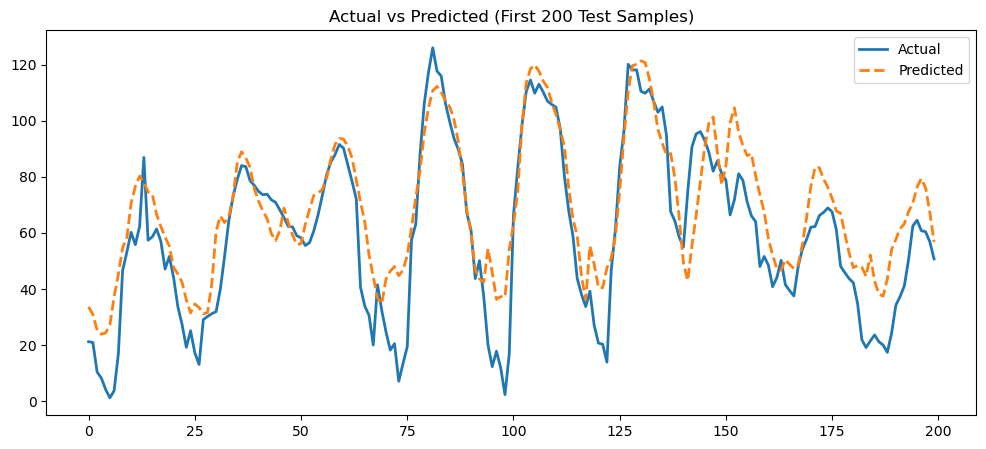

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test[:200], label="Actual", linewidth=2)
plt.plot(y_pred[:200], label="Predicted", linestyle="--", linewidth=2)
plt.legend()
plt.title("Actual vs Predicted (First 200 Test Samples)")
plt.show()


In [54]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test).ravel()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.4f}")


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 188.8877 - val_loss: 128.1697
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 182.5345 - val_loss: 125.5686
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 181.6541 - val_loss: 131.3882
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 176.6130 - val_loss: 120.8868
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 168.4181 - val_loss: 135.7671
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 168.8728 - val_loss: 113.5160
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 169.1040 - val_loss: 113.3399
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 168.6497 - val_loss: 99.5141
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 163.6689 - val_loss: 128.4729
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 169.9197 - val_loss: 176.9247
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 164.1105 - val_loss: 94.3028

In [55]:
mae_lstm = mae
rmse_lstm = rmse
r2_lstm  = r2

print("Saved LSTM metrics:", mae_lstm, rmse_lstm, r2_lstm)


Saved LSTM metrics: 10.852140734898105 14.062328633516417 0.7104835895937925


In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [57]:
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    GRU(32),
    Dropout(0.2),

    Dense(16, activation="relu"),
    Dense(1)   # regression output
])

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
gru_model.summary()


c:\Users\njaya\anaconda3\envs\airquality-ml\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 24, 64)         │        15,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,697 (100.38 KB)

 Trainable params: 25,697 (100.38 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

gru_history = gru_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 4224.1304 - val_loss: 1715.0221
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1603.6000 - val_loss: 569.5354
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1045.8500 - val_loss: 574.0066
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1033.2971 - val_loss: 576.2501
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1029.2682 - val_loss: 582.9620
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1027.0336 - val_loss: 587.3454
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 946.4713 - val_loss: 665.3104


In [59]:
y_pred_gru = gru_model.predict(X_test).ravel()

mse_gru = mean_squared_error(y_test, y_pred_gru)
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test, y_pred_gru)

print("GRU Performance:")
print(f"MAE : {mae_gru:.3f}")
print(f"RMSE: {rmse_gru:.3f}")
print(f"R²  : {r2_gru:.4f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
GRU Performance:
MAE : 22.564
RMSE: 28.536
R²  : -0.1922


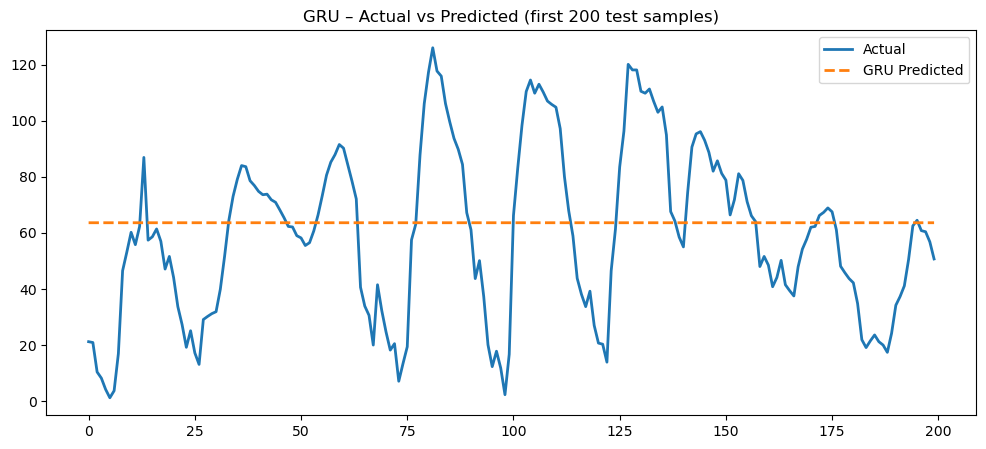

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test[:200], label="Actual", linewidth=2)
plt.plot(y_pred_gru[:200], label="GRU Predicted", linestyle="--", linewidth=2)
plt.legend()
plt.title("GRU – Actual vs Predicted (first 200 test samples)")
plt.show()


In [61]:
mae_gru  = mae_gru     # already named correctly
rmse_gru = rmse_gru
r2_gru   = r2_gru

print("Saved GRU metrics:", mae_gru, rmse_gru, r2_gru)


Saved GRU metrics: 22.564321076325854 28.536008341250973 -0.19218909741488344


In [62]:
import pandas as pd

rf_xgb = pd.read_csv("../reports/rf_xgb_results.csv")
rf_xgb


,Model,MAE,RMSE,R2
0,RandomForest,3.616325,5.952424,0.941639
1,XGBoost,3.421188,5.686689,0.946734


In [63]:
rf_mae  = rf_xgb.loc[rf_xgb["Model"] == "RandomForest", "MAE"].item()
rf_rmse = rf_xgb.loc[rf_xgb["Model"] == "RandomForest", "RMSE"].item()
rf_r2   = rf_xgb.loc[rf_xgb["Model"] == "RandomForest", "R2"].item()

xgb_mae  = rf_xgb.loc[rf_xgb["Model"] == "XGBoost", "MAE"].item()
xgb_rmse = rf_xgb.loc[rf_xgb["Model"] == "XGBoost", "RMSE"].item()
xgb_r2   = rf_xgb.loc[rf_xgb["Model"] == "XGBoost", "R2"].item()

print("RF:", rf_mae, rf_rmse, rf_r2)
print("XGB:", xgb_mae, xgb_rmse, xgb_r2)


RF: 3.61632522493056 5.9524237838304135 0.941639025870063
XGB: 3.421188135708784 5.686689288711169 0.9467335387790892


In [64]:
results = pd.DataFrame({
    "Model": ["RandomForest", "XGBoost", "LSTM", "GRU"],
    "MAE":   [rf_mae, xgb_mae, mae_lstm, mae_gru],
    "RMSE":  [rf_rmse, xgb_rmse, rmse_lstm, rmse_gru],
    "R2":    [rf_r2, xgb_r2, r2_lstm, r2_gru],
})

results


,Model,MAE,RMSE,R2
0,RandomForest,3.616325,5.952424,0.941639
1,XGBoost,3.421188,5.686689,0.946734
2,LSTM,10.852141,14.062329,0.710484
3,GRU,22.564321,28.536008,-0.192189


In [ ]:
##Based on the evaluation metrics, tree-based models significantly outperformed deep learning architectures.
##XGBoost achieved the best results overall with the lowest MAE (3.42) and RMSE (5.69), and the highest R² value (0.9467), indicating strong predictive accuracy and ability to explain variance.
##RandomForest ranked second but showed comparable performance to XGBoost.
##In contrast, LSTM and GRU underperformed, with RMSE values nearly 2–5× higher and lower R² scores, suggesting that the sequential models did not capture temporal dependencies effectively under the current dataset configuration.
##GRU showed negative R², indicating that it performed worse than simply predicting the mean.
##Therefore, XGBoost is the recommended model for final deployment and dashboard integration.

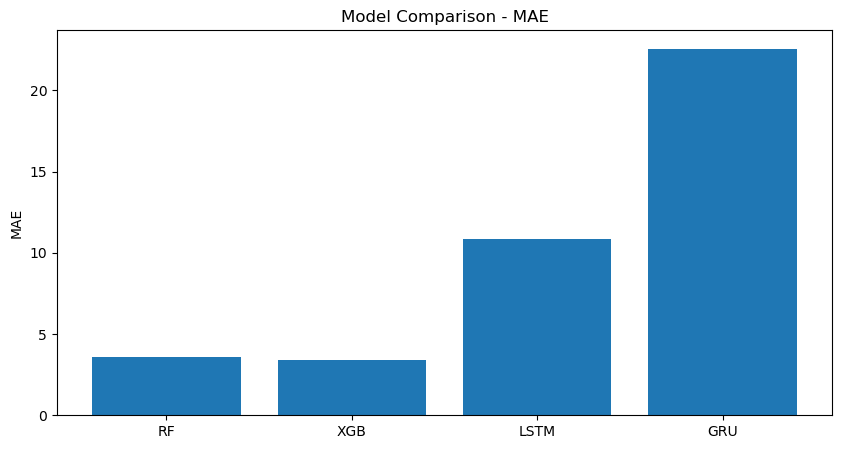

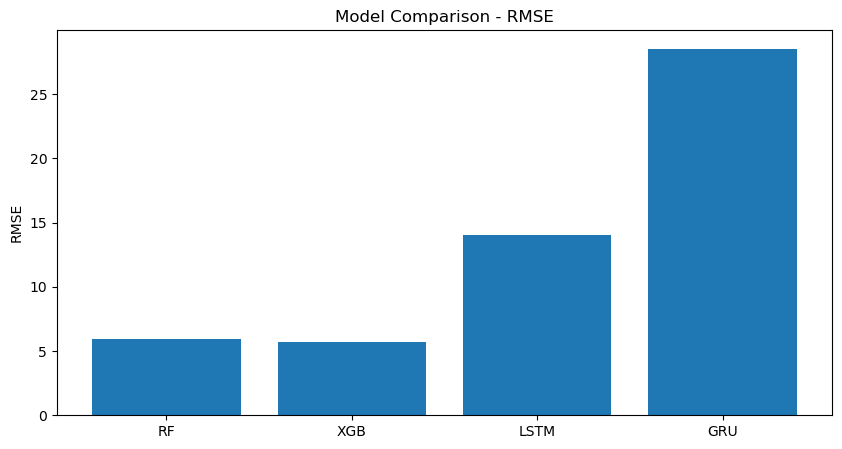

In [65]:
import matplotlib.pyplot as plt

models = ["RF", "XGB", "LSTM", "GRU"]
mae_values = [3.616, 3.421, 10.852, 22.564]
rmse_values = [5.952, 5.686, 14.062, 28.536]

plt.figure(figsize=(10,5))
plt.bar(models, mae_values)
plt.title("Model Comparison - MAE")
plt.ylabel("MAE")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(models, rmse_values)
plt.title("Model Comparison - RMSE")
plt.ylabel("RMSE")
plt.show()
